In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import random_projection
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import kneighbors_graph

In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
with open("/home/luca/ml-malware-concept-drift/data/dataset/dataset.pickle", "rb") as f:
    df_1 = pickle.load(f).reset_index()
    print(df_1.shape)

with open("/home/luca/ml-malware-concept-drift/data/dataset/dataset_opcodes.pickle", "rb") as f:
    df_opcodes = pickle.load(f).reset_index()
    print(df_opcodes.shape)

df = pd.merge(left=df_1, right=df_opcodes, on="sample_hash")
df = df.drop(["ms_elapsed", "pesectionProcessed_entrypointSection_name"], axis=1)
df.head()

(67000, 42232)
(67000, 2501)


,sample_hash,generic_fileSize,generic_fileEntropy,header_SizeOfHeaders,header_AddressOfEntryPoint,header_ImageBase,header_SizeOfImage,header_SizeOfCode,header_SizeOfInitializedData,header_SizeOfUninitializedData,...,opcode_movzx movzx add,opcode_stosd stosd stosd,opcode_sub je push,opcode_je nop,opcode_add adc mov,opcode_mov mov nop,opcode_mov adc mov,opcode_adc mov mov,opcode_cmove,opcode_cmovne
0,cfa2d5eeac7de9f134cb2e36d54a5c4053f62fdf9d5302...,1666137,7.996651,1024,5358807,4194304,5365760,310272,56832,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00ebebc75f61527282cee19ab7aed80693b63fbb969e71...,10543104,4.821304,4096,4512,4194304,118784,94208,20480,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f45e6ca3a2bbbaa1c514d81abe9daaa47f7d41da500e69...,57368,4.979988,4096,9759,4194304,57344,8192,45056,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d694a203bb211751669f8742db877e8ebd5eff5b126abc...,7922688,7.950081,1024,155508,4194304,7950336,570880,7350784,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15c9feb810c48ffef1c7e32cbe58a11037da94e958fb1f...,159744,5.911521,4096,86524,4194304,159744,86016,69632,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.set_index("sample_hash")
X1 = scaler.fit_transform(X)

In [6]:
X1

array([[-0.10393396,  0.98302712, -0.00399457, ..., -0.30353129,
        -0.27651138, -0.28151998],
       [ 0.41145816, -1.19250887, -0.00379288, ..., -0.30353129,
        -0.27651138, -0.28151998],
       [-0.19733826, -1.08378882, -0.00379288, ..., -0.30353129,
        -0.27651138, -0.28151998],
       ...,
       [-0.19625023, -1.41316053, -0.00399457, ..., -0.30353129,
        -0.27651138, -0.28151998],
       [-0.19625023, -1.41293517, -0.00399457, ..., -0.30353129,
        -0.27651138, -0.28151998],
       [-0.19337407, -0.35696588, -0.00379288, ..., -0.30353129,
        -0.27651138, -0.28151998]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
reduced = pca.fit_transform(X1)

In [ ]:
reduced.shape

In [7]:
np.save("reduced1.npy", reduced)

In [ ]:
#X.to_csv("dataset_final.csv")

In [6]:
# transformer = random_projection.GaussianRandomProjection()
# X_new = transformer.fit_transform(X)
# X_new.shape

(67000, 9524)

In [7]:
knn_graph = kneighbors_graph(X_new, 20, include_self=False)

/home/luca/ml-malware-concept-drift/venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:322: UserWarning: the number of connected components of the connectivity matrix is 29 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


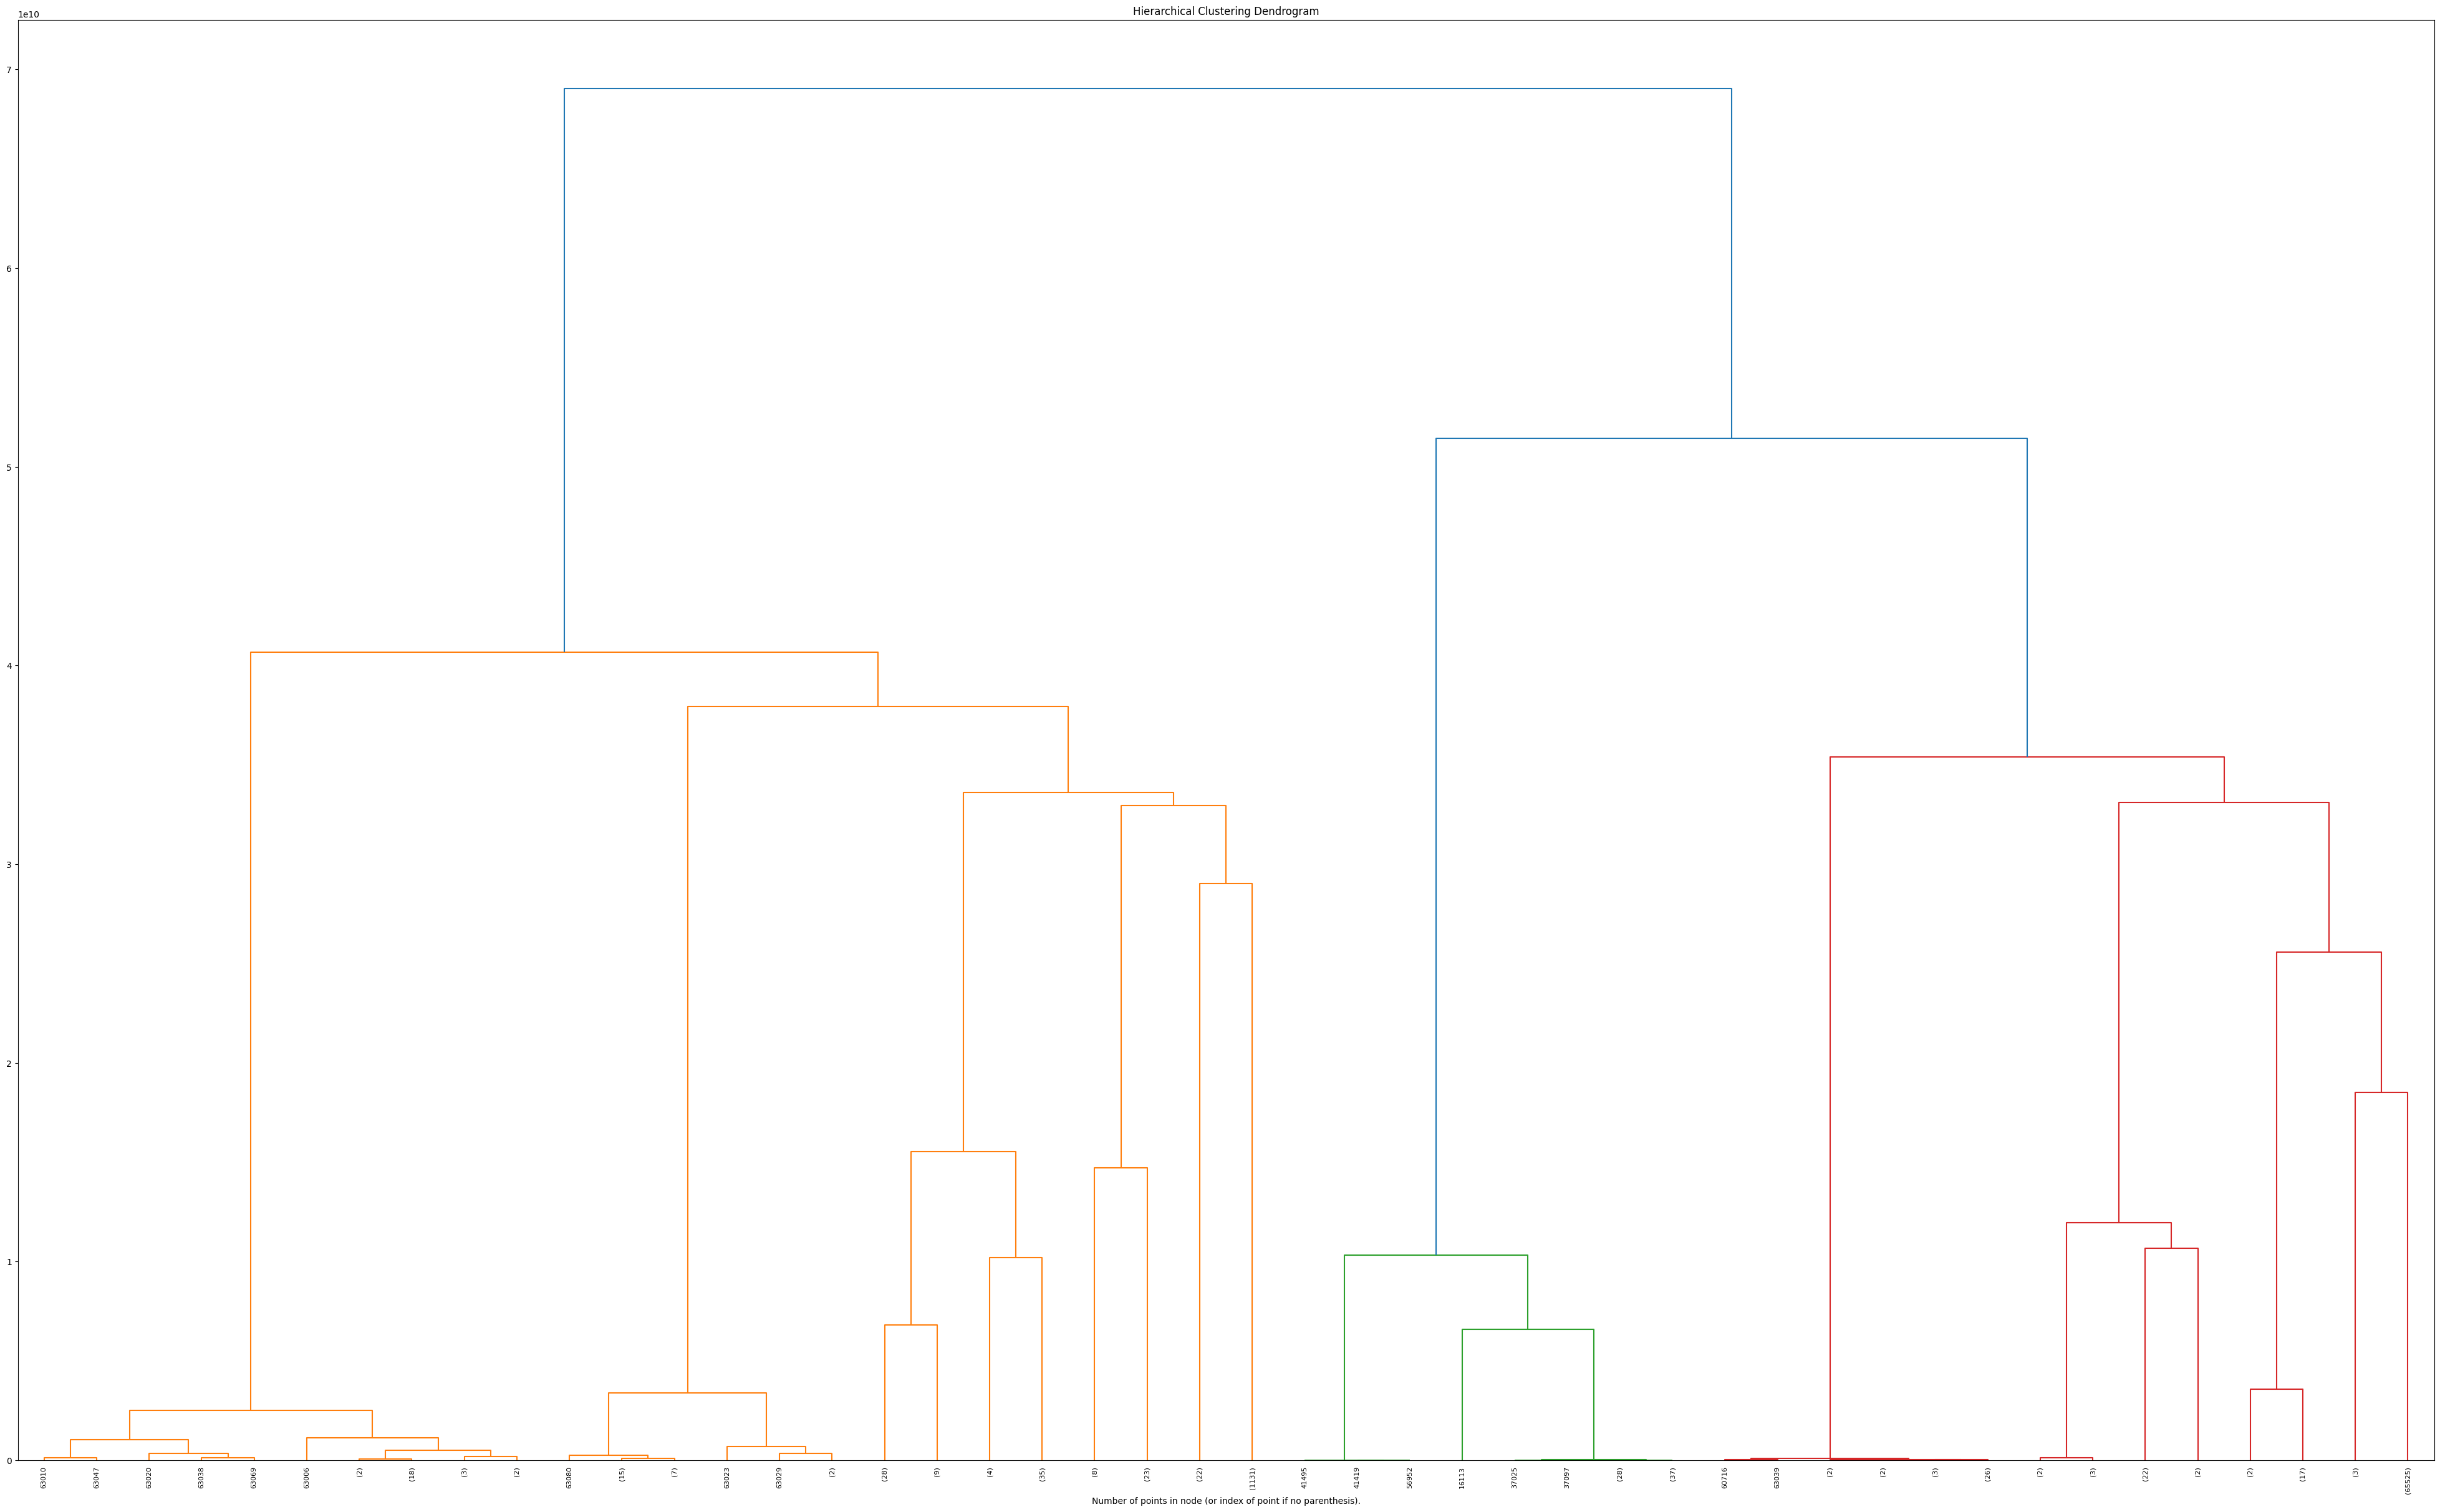

In [8]:
model = AgglomerativeClustering(
    linkage="ward",
    connectivity=knn_graph,
    distance_threshold=0, 
    n_clusters=None
)
model = model.fit(X_new)
plt.figure(figsize=(50, 30))
plt.title(f"Hierarchical Clustering Dendrogram")
# plot the top ten levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig("img/aggl_clust_kneigh_20_full_dend_rp.svg")
plt.show()

In [9]:
# It is important to use binary access
with open('models/aggl_clust_kneigh_20_full_dend_rp.pickle', 'wb') as f:
    pickle.dump(model, f)

In [10]:
knn_graph1 = kneighbors_graph(X_new, 5, include_self=False)
model1 = AgglomerativeClustering(
    linkage="ward",
    connectivity=knn_graph1,
    distance_threshold=0, 
    n_clusters=None
)
model1 = model.fit(X_new)

/home/luca/ml-malware-concept-drift/venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:322: UserWarning: the number of connected components of the connectivity matrix is 29 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


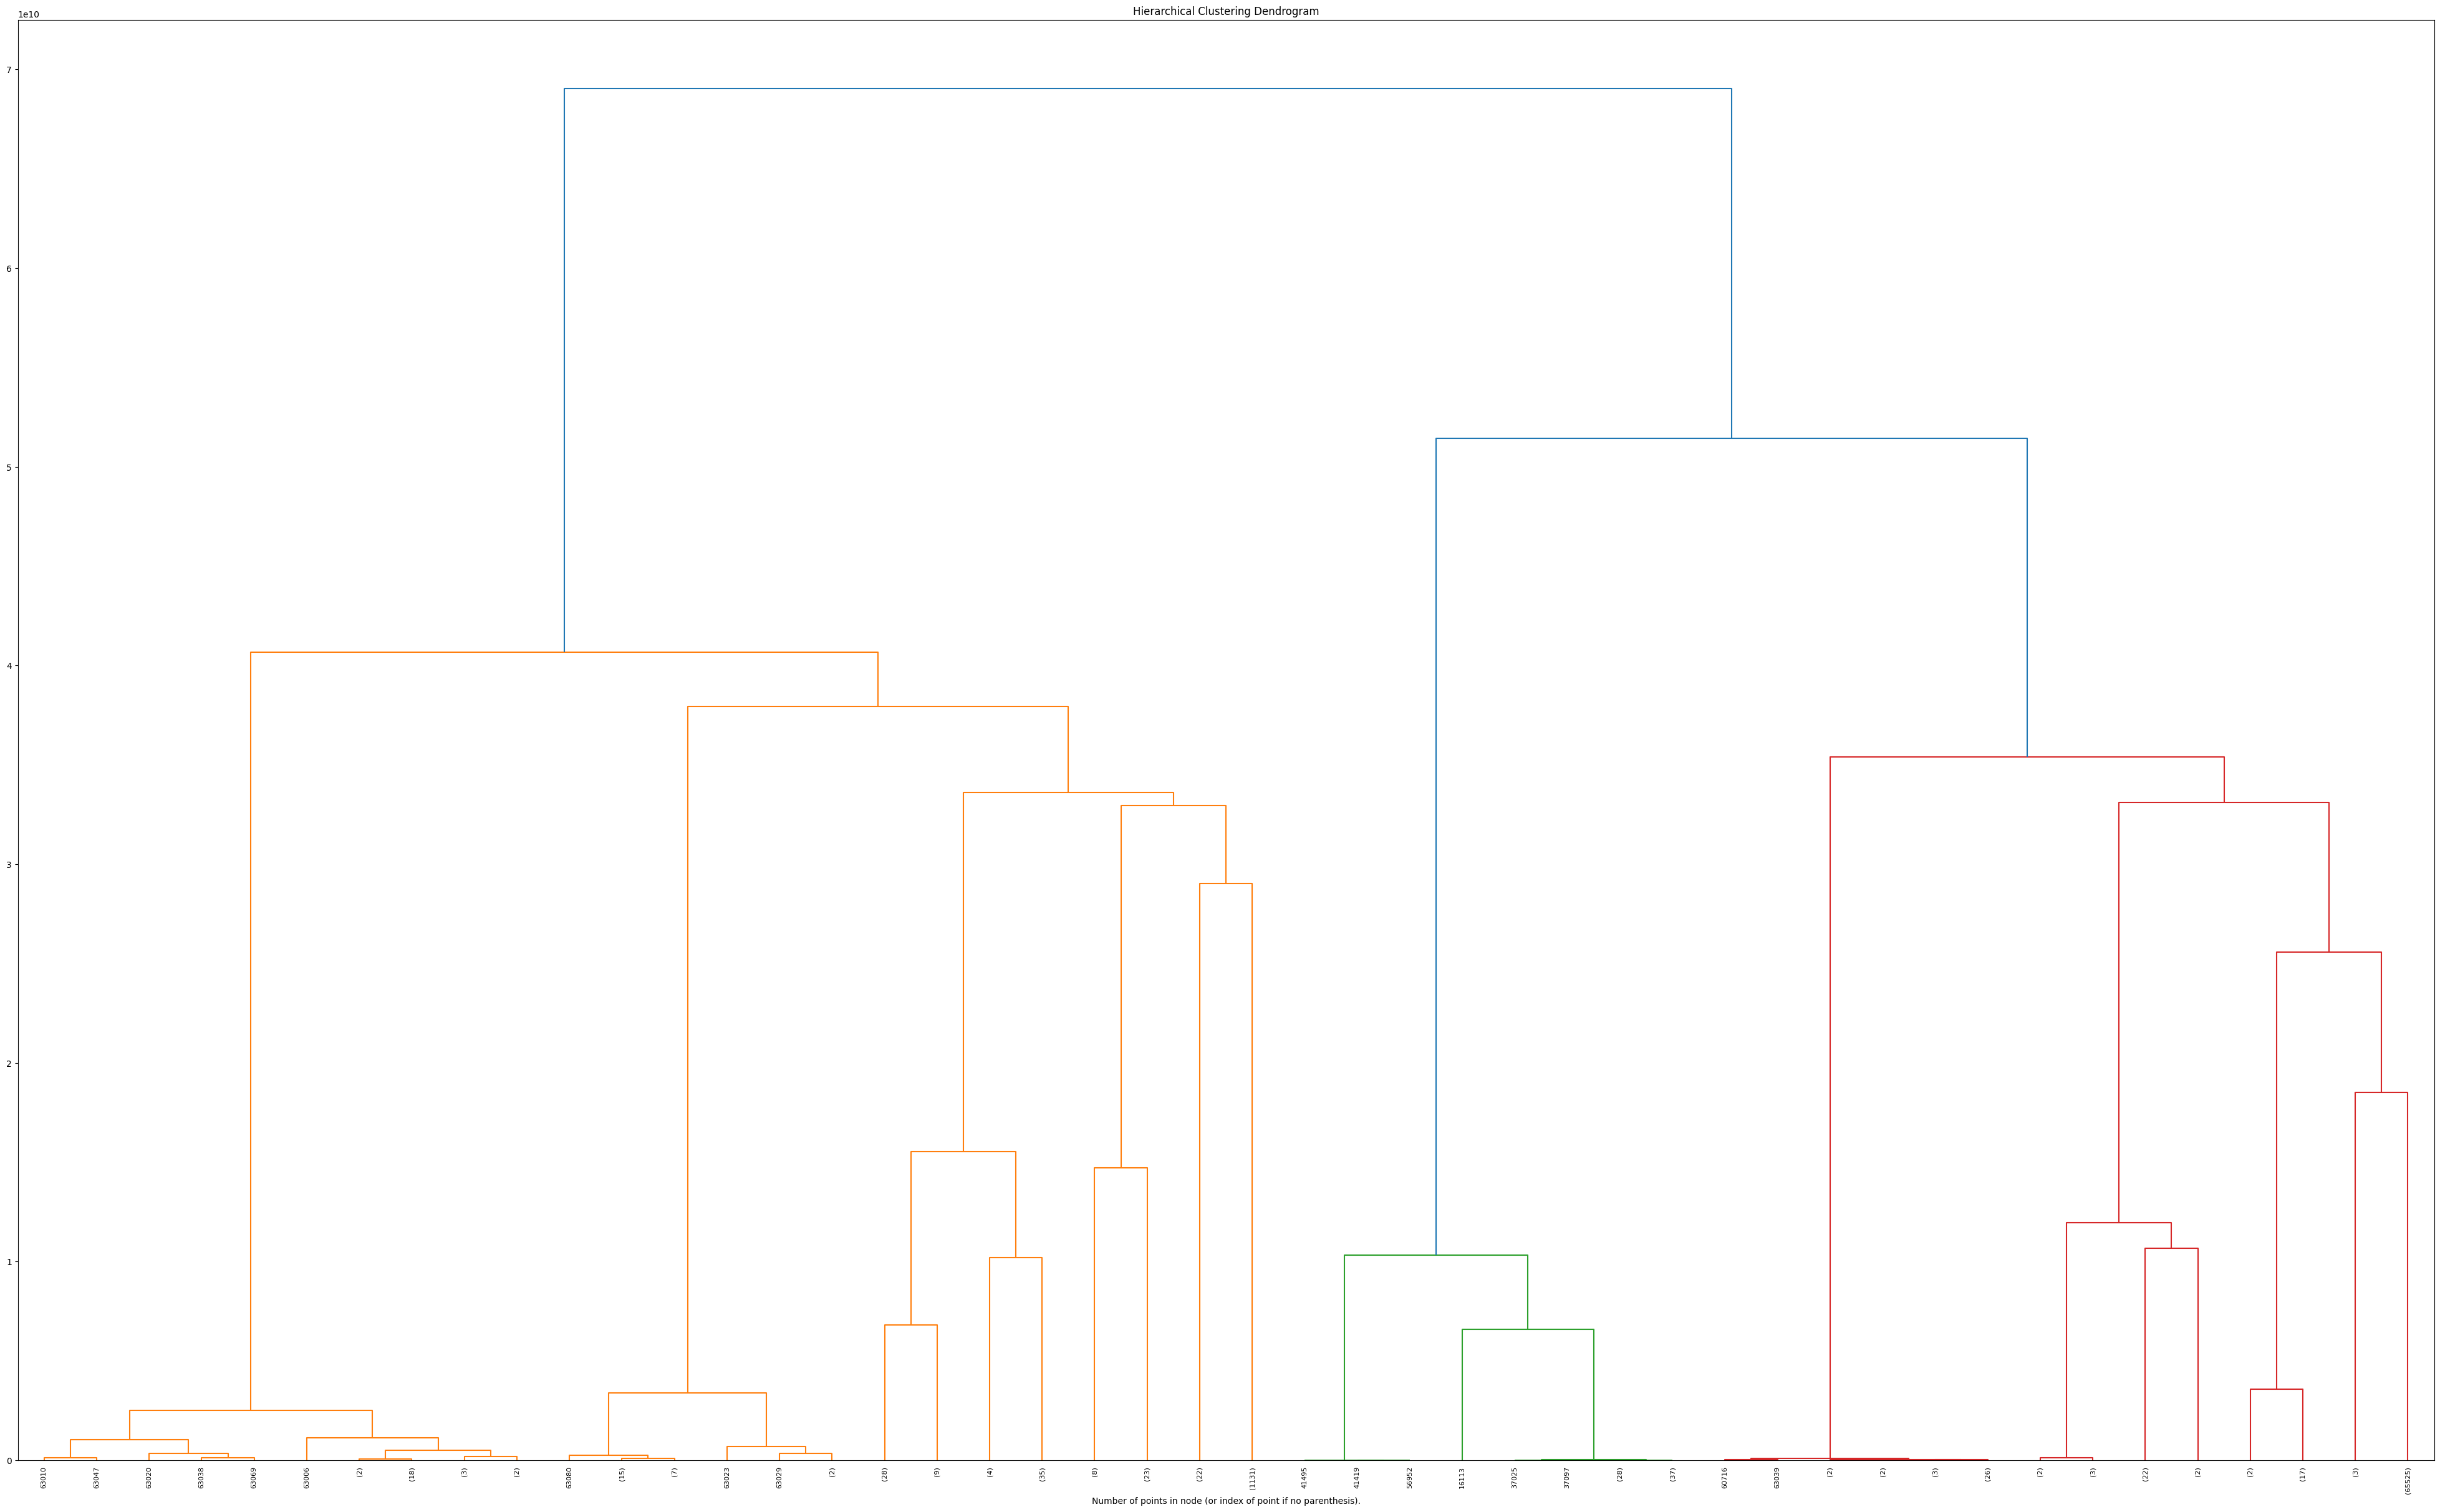

In [11]:
plt.figure(figsize=(50, 30))
plt.title(f"Hierarchical Clustering Dendrogram")
# plot the top ten levels of the dendrogram
plot_dendrogram(model1, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig("img/aggl_clust_kneigh_5_full_dend_rp.svg")
plt.show()

In [12]:
# It is important to use binary access
with open('models/aggl_clust_kneigh_5_full_dend_rp.pickle', 'wb') as f:
    pickle.dump(model, f)

In [1]:
from sklearn.cluster import HDBSCAN
hdb = HDBSCAN(n_jobs=-1, store_centers="centroid")
labels_hdb = hdb.fit_predict(X_new)

NameError: name 'X_new' is not defined